In [1]:
import barwisemusiccompression.ae_utils as ae_utils
import barwisemusiccompression.ae as ae
import barwisemusiccompression.lra as lra
import barwisemusiccompression.scripts.default_path as paths
import barwisemusiccompression.scripts.overall_scripts as scr

import as_seg.CBM_algorithm as CBM
import as_seg.barwise_input as bi
import as_seg.data_manipulation as dm
import as_seg.autosimilarity_computation as as_comp
#import as_seg.barwise_input as bi
from musicntd.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl
import matplotlib.patches as mpatches

In [2]:
colors = ['tab:green', 'tab:purple','tab:red','tab:olive']
markers = ['^', 's', 'o','v']

convolution_type = "14_bands"
autosimilarity_types = ["Cosine", "Covariance", "RBF"]
pen_function = "modulo8"
feature = "log_mel_grill"

compression_labels = ["SSAE"]

dimensions_range = [8,16,24,32,40]

In [3]:
def return_results(references_segments, segments_in_time):
    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)
    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)
    return [[round(prec05,4),round(rap05,4),round(f_mes05,4)], [round(prec3,4),round(rap3,4),round(f_mes3,4)]]

In [4]:
def plot_kernels_as(results_diff_as, kernels_or_features, autosimilarities, tol, title = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
    if len(autosimilarities) == 2:
        colors = ["#62d5b4", "#184a4a"]

    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim( 25, 105 )
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        tab.append(ax.bar(indexes, results_diff_as[:,i,tol], color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            height = results_diff_as[idx_x, i, tol] 
            plt.text(x +width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left')
    else:
        ax.legend(labels=subaxis, loc='upper left')

    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

# Linear methods

In [5]:
# EUC NMF
features = ["Mel","NNLMS","Chromagram"]
f_mes_cosine_zerofive = [51.12, 57.62, 55.45]
f_mes_cosine_three = [72.80,75.33,71.98]

f_mes_covariance_zerofive = [50.84,58.26,55.61]
f_mes_covariance_three = [68.77,71.37, 68.38, ]

f_mes_rbf_zerofive = [49.48, 59.78, 59.10]
f_mes_rbf_three = [70.49,76.18, 72.66]

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2))
for idx_f in range(len(features)):
    res_avg_target[idx_f, 0, 0] = f_mes_cosine_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_cosine_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_covariance_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_covariance_three[idx_f]
    res_avg_target[idx_f, 2, 0] = f_mes_rbf_zerofive[idx_f]
    res_avg_target[idx_f, 2, 1] = f_mes_rbf_three[idx_f]

all_results = np.array([[f_mes_cosine_zerofive, f_mes_cosine_three], [f_mes_covariance_zerofive, f_mes_covariance_three],
              [f_mes_rbf_zerofive, f_mes_rbf_three]])
plot_kernels_as(res_avg_target, features, autosimilarity_types, 0, title = None)#f"F0.5 for Euclidean-NMF on RWC Pop,\n with the different autosimilarities.")
plot_kernels_as(res_avg_target, features, autosimilarity_types, 1, title = None)#f"F3 for Euclidean-NMF on RWC Pop,\n with the different autosimilarities.")


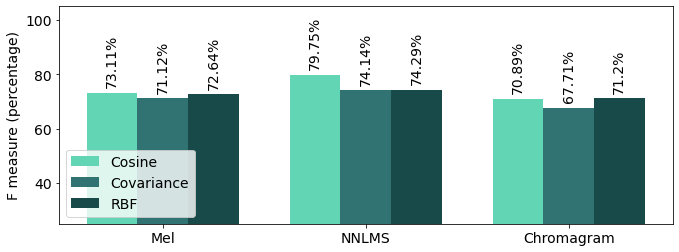

In [6]:
# KL NMF
features = ["Mel","NNLMS","Chromagram"]
f_mes_cosine_zerofive = [54.03, 61.64, 53.39]
f_mes_cosine_three = [73.11, 79.75, 70.89]

f_mes_covariance_zerofive = [55.84,57.89,55.46]
f_mes_covariance_three = [71.12, 74.14, 67.71]

f_mes_rbf_zerofive = [53.65, 56.04, 55.84]
f_mes_rbf_three = [72.64, 74.29, 71.20]

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2))
for idx_f in range(len(features)):
    res_avg_target[idx_f, 0, 0] = f_mes_cosine_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_cosine_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_covariance_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_covariance_three[idx_f]
    res_avg_target[idx_f, 2, 0] = f_mes_rbf_zerofive[idx_f]
    res_avg_target[idx_f, 2, 1] = f_mes_rbf_three[idx_f]

all_results = np.array([[f_mes_cosine_zerofive, f_mes_cosine_three], [f_mes_covariance_zerofive, f_mes_covariance_three],
              [f_mes_rbf_zerofive, f_mes_rbf_three]])
plot_kernels_as(res_avg_target, features, autosimilarity_types, 0, title = None)#f"F0.5 for Euclidean-NMF on RWC Pop,\n with the different autosimilarities.")
plot_kernels_as(res_avg_target, features, autosimilarity_types, 1, title = None)#f"F3 for Euclidean-NMF on RWC Pop,\n with the different autosimilarities.")


In [ ]:
#NTD diff loss with NTD

f_mes_btf_zerofive = [55.88, 49.92,45.16]
f_mes_btf_three = [74.71, 67.26,65.48]

f_mes_ntd_zerofive = [57.42,61.79,61.71]
f_mes_ntd_three = [76.34,80.37,76.36]

f_mes_eucnmf_zerofive = [51.12, 57.62,55.45]
f_mes_eucnmf_three = [72.80,75.33,71.98]

f_mes_klnmf_zerofive = [54.03,61.64,53.39]
f_mes_klnmf_three = [73.11,79.75,70.89]

f_mes_isnmf_zerofive = [54.84,58.23,53.78]
f_mes_isnmf_three = [73.59,77.30,67.20]

def plot_kernels_as(all_results, kernels, autosimilarities, tol):
    #Adapter all_rsults et ses indices avec besoin, à c'est as, tol, kernels, pas forcément optimal
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    colors = ['skyblue', 'darkorange', 'limegreen', 'forestgreen', 'darkgreen'] #'steelblue',

    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim( 40, 100)
    tab = []
    current_start = 0
    for idx_as in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels))]
        tab.append(ax.bar(indexes, all_results[idx_as,tol,:], color=colors[idx_as], width=width))
        for idx_x, x in enumerate(indexes):
            height = all_results[idx_as, tol, idx_x] 
            if height > 0:
                plt.text(x,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2.6 + j*gap for j in range(len(kernels))])
    ax.set_xticklabels(kernels)
    if tol == 0:
        ax.legend(labels=subaxis, loc='upper left')
        #ax.set_title('Segmentation results ')
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left')
    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')

    plt.show()
    
all_results = np.array([[f_mes_btf_zerofive, f_mes_btf_three], [f_mes_ntd_zerofive, f_mes_ntd_three],
              [f_mes_eucnmf_zerofive, f_mes_eucnmf_three],[f_mes_klnmf_zerofive, f_mes_klnmf_three],[f_mes_isnmf_zerofive, f_mes_isnmf_three]])

plot_kernels_as(all_results, autosimilarities = ['Barwise TF', 'Best NTD', 'Euclidean-NMF', 'KL-NMF', 'IS-NMF'], kernels = ["Mel","NNLMS", "Chromagram"], tol = 0)
plot_kernels_as(all_results, autosimilarities = ['Barwise TF', 'Best NTD', 'Euclidean-NMF', 'KL-NMF', 'IS-NMF'], kernels = ["Mel","NNLMS", "Chromagram"], tol = 1)

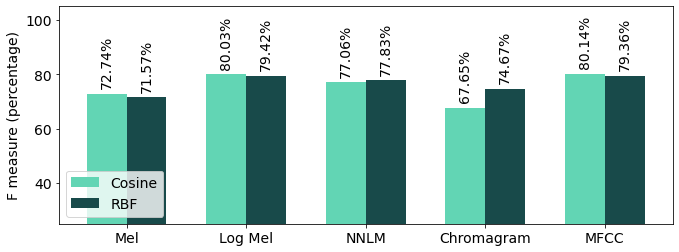

In [7]:
# PCA
features = ["Mel","Log Mel","NNLM","Chromagram","MFCC"]
f_mes_cosine_zerofive = [54.09,64.17,64.30, 53.31,64.06]
f_mes_cosine_three = [72.74,80.03,77.06,67.65, 80.14]

f_mes_rbf_zerofive = [52.73,61.71,59.29,57.91,61.19]
f_mes_rbf_three = [71.57,79.42,77.83,74.67,79.36]

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2))
for idx_f in range(len(features)):
    res_avg_target[idx_f, 0, 0] = f_mes_cosine_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_cosine_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_rbf_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_rbf_three[idx_f]

plot_kernels_as(res_avg_target, features, ["Cosine", "RBF"], 0, title = None)#f"F0.5 for PCA on RWC Pop,\n with the different autosimilarities.")
plot_kernels_as(res_avg_target, features, ["Cosine", "RBF"], 1, title = None)#f"F3 for PCA on RWC Pop,\n with the different autosimilarities.")


In [ ]:
#Comparison Linear methods
f_mes_btf_zerofive = [55.88, 59.65, 49.92,45.16,48.98]
f_mes_btf_three = [74.71, 74.03,67.26,65.48,67.15]

#f_mes_ntd_zerofive = [46.51,0,56.97,61.71,0]
#f_mes_ntd_three = [69.66,0,74.63,76.36,0]
f_mes_ntd_zerofive = [46.51,0,56.97,61.71,0]
f_mes_ntd_three = [69.66,0,74.63,76.36,0]

f_mes_nmf_zerofive = [51.12, 0,57.62,55.45,0]
f_mes_nmf_three = [72.80,0,75.33,71.98,0]

f_mes_pca_zerofive = [54.09,64.17,64.30,53.31,64.06]
f_mes_pca_three = [72.74,80.03,77.06,67.55,80.14]

f_mes_mel_zerofive = [55.88, 46.51,51.12,54.09]
f_mes_mel_three = [74.71, 69.66,72.80, 72.74]

f_mes_log_mel_zerofive = [59.65, 0,0,64.17]
f_mes_log_mel_three = [74.03,0,0,80.03]

f_mes_nnlms_zerofive = [49.92, 56.97,57.62, 64.30]
f_mes_nnlms_three = [67.26, 74.63,75.33,77.06]

f_mes_pcp_zerofive = [45.16, 61.71,55.45,53.31]
f_mes_pcp_three = [65.48, 76.36,71.98,67.55]

f_mes_mfcc_zerofive = [48.98,0,0,64.06]
f_mes_mfcc_three = [67.15,0,0,80.14]

def plot_kernels_as(all_results, kernels, autosimilarities, tol):
    #Adapter all_rsults et ses indices avec besoin, à c'est as, tol, kernels, pas forcément optimal
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    
    width=0.25
    gap = (len(autosimilarities) + 2)*width
    colors = ['skyblue', 'darkorange', 'indianred', 'brown'] #'steelblue',

    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim( 40, 100)
    tab = []
    current_start = 0
    for idx_as in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels))]
        tab.append(ax.bar(indexes, all_results[idx_as,tol,:], color=colors[idx_as], width=width))
        for idx_x, x in enumerate(indexes):
            height = all_results[idx_as, tol, idx_x] 
            if height > 0:
                plt.text(x,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2.6 + j*gap for j in range(len(kernels))])
    ax.set_xticklabels(kernels)
    if tol == 0:
        ax.legend(labels=subaxis, loc='upper left')
        #ax.set_title('Segmentation results ')
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left')
    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')

    plt.show()
    
all_results = np.array([[f_mes_btf_zerofive, f_mes_btf_three], [f_mes_ntd_zerofive, f_mes_ntd_three],
              [f_mes_nmf_zerofive, f_mes_nmf_three],[f_mes_pca_zerofive, f_mes_pca_three]])

plot_kernels_as(all_results, autosimilarities = ['Barwise TF', 'Euclidean-NTD', 'Euclidean-NMF', 'PCA'], kernels = ["Mel","Log Mel","NNLMS", "Chromagram","MFCC"], tol = 0)
plot_kernels_as(all_results, autosimilarities = ['Barwise TF', 'Euclidean-NTD', 'Euclidean-NMF', 'PCA'], kernels = ["Mel","Log Mel","NNLMS", "Chromagram","MFCC"], tol = 1)

# SSAE

In [7]:
def plot_features_as_ae(results_diff_as, kernels_or_features, autosimilarities, tol, title = None, colors = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    color_patches = []
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    if colors is None:
        colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
        if len(autosimilarities) == 2:
            colors = ["#62d5b4", "#184a4a"]

    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim(37,80)# 35,80)
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        boxprops = dict(linewidth=0.5, color='black')
        medianprops = dict(linewidth=0.5, color='white')
        tab.append(ax.boxplot(results_diff_as[:,i,tol,:].T, positions=indexes, widths = [width for i in range(len(indexes))],
                              boxprops = boxprops, medianprops = medianprops,patch_artist=True))#, color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes):
            tab[-1]['boxes'][idx_x].set( facecolor = colors[i] )
            height = round(np.median(results_diff_as[idx_x, i, tol,:]), 2)
            max_val = round(np.amax(results_diff_as[idx_x, i, tol,:]), 2)
            plt.text(x,max_val + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width
        
        color_patches.append(mpatches.Patch(color=colors[i], label=subaxis[i]))

    ax.set_xticks([current_start/3 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(handles=color_patches,labels=subaxis, loc='lower left')
    else:
        ax.legend(handles=color_patches,labels=subaxis, loc='upper left')

    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

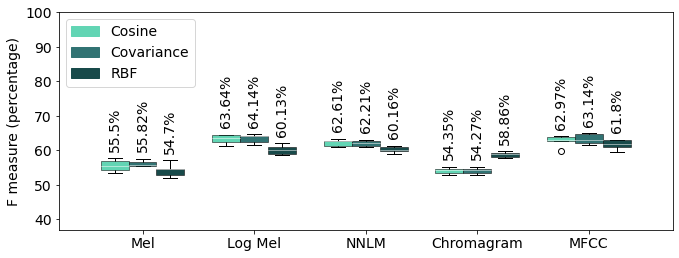

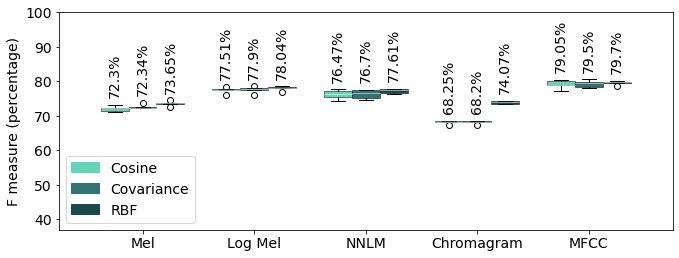

In [9]:
#Conv #RWC POP
features = ["Mel","Log Mel","NNLM","Chromagram","MFCC"]
f_mes_cosine_zerofive = [[0.54326, 0.57023, 0.53474, 0.5775, 0.55502],
                         [0.62321, 0.64388, 0.63636, 0.64488, 0.61355],
                         [0.60953, 0.62613, 0.63443, 0.62677, 0.61382],
                         [0.54348, 0.52759, 0.54748, 0.535, 0.55214],
                         [0.62726, 0.5987, 0.64127, 0.63951, 0.62968]]
f_mes_cosine_three = [[0.71449, 0.73217, 0.71017, 0.72412, 0.72304],
                      [0.77462, 0.7776, 0.77509, 0.78421, 0.76087],
                      [0.7441, 0.77194, 0.77721, 0.7647, 0.7535],
                      [0.68659, 0.67358, 0.68128, 0.68246, 0.68634],
                      [0.80074, 0.77206, 0.80391, 0.79053, 0.78882]]
f_mes_cov_zerofive = [[0.55819, 0.56558, 0.55527, 0.57608, 0.556],
                      [0.62364, 0.64142, 0.64156, 0.64639, 0.61524],
                      [0.6103, 0.62715, 0.63078, 0.62209, 0.61151],
                      [0.54269, 0.52759, 0.54748, 0.53456, 0.55214],
                      [0.63139, 0.61571, 0.64658, 0.64966, 0.62117]]
f_mes_cov_three = [[0.7217, 0.73807, 0.72152, 0.72543, 0.72345],
                   [0.77641, 0.77897, 0.77958, 0.78546, 0.76107],
                   [0.74662, 0.77567, 0.77596, 0.76697, 0.75271],
                   [0.68586, 0.67358, 0.68128, 0.68202, 0.68634],
                   [0.79829, 0.7839, 0.80624, 0.79497, 0.78163]]

f_mes_rbf_zerofive = [[0.54695, 0.52856, 0.5205, 0.57193, 0.54695],
                      [0.60132, 0.58886, 0.58602, 0.61064, 0.62116],
                      [0.60163, 0.61336, 0.59099, 0.60996, 0.59975],
                      [0.58006, 0.59189, 0.58858, 0.57824, 0.59738],
                      [0.59525, 0.61798, 0.63, 0.63136, 0.60849]]
f_mes_rbf_three = [[0.73384, 0.7268, 0.73649, 0.74518, 0.73797],
                   [0.78468, 0.78605, 0.76844, 0.78044, 0.77975],
                   [0.76372, 0.77886, 0.76522, 0.77896, 0.77608],
                   [0.73435, 0.74073, 0.7424, 0.73339, 0.74455],
                   [0.7996, 0.80126, 0.79622, 0.79696, 0.78702]]

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 5))
for idx_f in range(len(features)):
    res_avg_target[idx_f, 0, 0] = f_mes_cosine_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_cosine_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_cov_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_cov_three[idx_f]
    res_avg_target[idx_f, 2, 0] = f_mes_rbf_zerofive[idx_f]
    res_avg_target[idx_f, 2, 1] = f_mes_rbf_three[idx_f]
res_avg_target *= 100
plot_features_as_ae(res_avg_target, features, ["Cosine", "Covariance", "RBF"], 0, title = None)#f"F0.5 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")
plot_features_as_ae(res_avg_target, features, ["Cosine", "Covariance", "RBF"], 1, title = None)#f"F3 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")

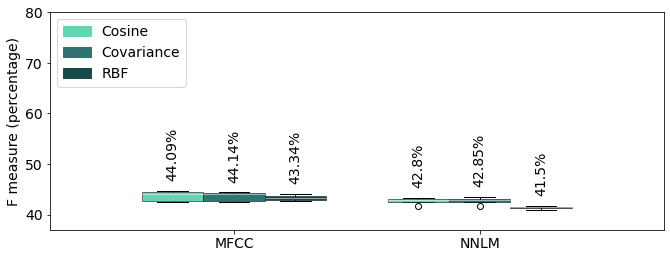

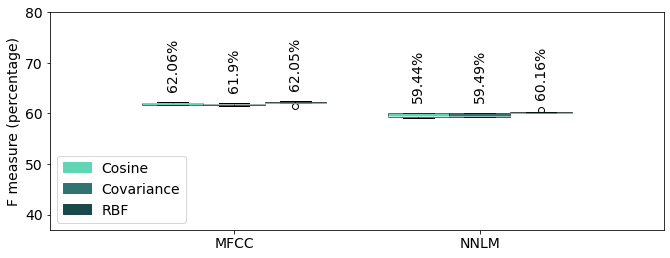

In [8]:
#Conv SALAMI
features = ["MFCC","NNLM"]
f_mes_cosine_zerofive = [[0.44535086, 0.44092309, 0.44660105, 0.42516336, 0.42793862],
                        [0.41609932, 0.43013058, 0.43250874, 0.42804781, 0.42559032]]
f_mes_cosine_three = [[0.62059405, 0.62112115, 0.62235493, 0.61600931, 0.61767112],
                      [0.59135224, 0.59319495, 0.60005249, 0.60096409, 0.59441943]]

f_mes_cov_zerofive = [[0.4427298,  0.44139073, 0.44386597, 0.42619397, 0.42568718],
                      [0.41708112, 0.43084462, 0.43441235, 0.42847411, 0.42574581]]
f_mes_cov_three = [[0.61921938, 0.61904466, 0.62130144, 0.6161043,  0.61465475],
                   [0.59215286, 0.59333045, 0.60062745, 0.60097415, 0.59490455]]

f_mes_rbf_zerofive = [[0.42778744, 0.43598561, 0.44082412, 0.42919975, 0.43338356],
                      [0.40827219, 0.41501422, 0.41274355, 0.41605585, 0.41659801]]
f_mes_rbf_three = [[0.6149345,  0.62052504, 0.62447298, 0.62304893, 0.62000287],
                   [0.60199767, 0.60014091, 0.60645477, 0.6003284,  0.60160272]]

res_avg_target = math.inf * np.ones((len(features), len(autosimilarity_types), 2, 5))
for idx_f in range(len(features)):
    res_avg_target[idx_f, 0, 0] = f_mes_cosine_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_cosine_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_cov_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_cov_three[idx_f]
    res_avg_target[idx_f, 2, 0] = f_mes_rbf_zerofive[idx_f]
    res_avg_target[idx_f, 2, 1] = f_mes_rbf_three[idx_f]
res_avg_target *= 100
plot_features_as_ae(res_avg_target, features, ["Cosine", "Covariance", "RBF"], 0, title = None)#f"F0.5 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")
plot_features_as_ae(res_avg_target, features, ["Cosine", "Covariance", "RBF"], 1, title = None)#f"F3 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")

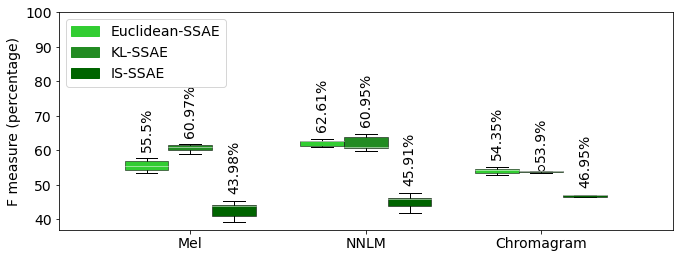

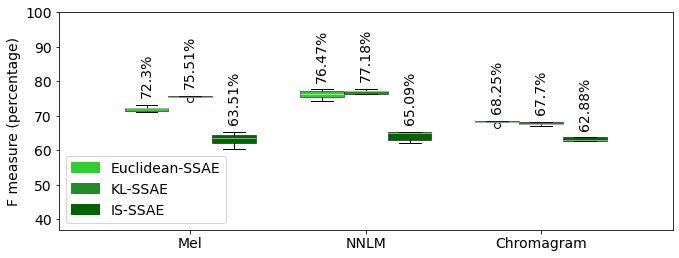

In [11]:
#Conv BETA
colors_beta = ['limegreen', 'forestgreen', 'darkgreen']
features = ["Mel","NNLM","Chromagram"]
f_mes_euc_zerofive = [[0.54326, 0.57023, 0.53474, 0.5775, 0.55502],
                      [0.60953, 0.62613, 0.63443, 0.62677, 0.61382],
                      [0.54348, 0.52759, 0.54748, 0.535, 0.55214]]
f_mes_euc_three = [[0.71449, 0.73217, 0.71017, 0.72412, 0.72304],
                   [0.7441, 0.77194, 0.77721, 0.7647, 0.7535],
                   [0.68659, 0.67358, 0.68128, 0.68246, 0.68634]]

f_mes_kl_zerofive = [[0.59074, 0.60973, 0.60138, 0.61678, 0.61786],
                     [0.59952, 0.64797, 0.60699, 0.63844, 0.60948],
                     [0.53904, 0.53494, 0.53986, 0.53611, 0.54848]]
f_mes_kl_three = [[0.75493, 0.74849, 0.75755, 0.75512, 0.75867],
                  [0.76295, 0.7789, 0.76313, 0.77177, 0.77183],
                  [0.67571, 0.67701, 0.68334, 0.67213, 0.68283]]

f_mes_is_zerofive = [[0.39139, 0.45342, 0.41104, 0.43985, 0.44188],
                     [0.41796, 0.47712, 0.46281, 0.43976, 0.4591],
                     [0.47105, 0.47162, 0.46948, 0.46364, 0.46359]]
f_mes_is_three = [[0.60306, 0.64422, 0.63506, 0.62139, 0.65334],
                  [0.62878, 0.65282, 0.65087, 0.62253, 0.6532],
                  [0.62882, 0.62852, 0.63834, 0.62743, 0.63782]]

res_avg_target = math.inf * np.ones((3, 3, 2, 5)) #Features, beta
for idx_f in range(len(features)):
    res_avg_target[idx_f, 0, 0] = f_mes_euc_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_euc_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_kl_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_kl_three[idx_f]
    res_avg_target[idx_f, 2, 0] = f_mes_is_zerofive[idx_f]
    res_avg_target[idx_f, 2, 1] = f_mes_is_three[idx_f]
res_avg_target *= 100
plot_features_as_ae(res_avg_target, features, ["Euclidean-SSAE", "KL-SSAE", "IS-SSAE"], 0, title = None, colors = colors_beta)#f"F0.5 for the Conv SSAE on RWC Pop,\n with the different loss functions.", colors = colors_beta)
plot_features_as_ae(res_avg_target, features, ["Euclidean-SSAE", "KL-SSAE", "IS-SSAE"], 1, title = None, colors = colors_beta)#f"F3 for the Conv SSAE on RWC Pop,\n with the different loss functions.", colors = colors_beta)

In [ ]:
# Comparison SSAE NMF PCA
f_mes_btf_zerofive = [55.88, 59.65, 49.92,45.16,48.98]
f_mes_btf_three = [74.71, 74.03,67.26,65.48,67.15]

f_mes_ntd_zerofive = [46.51,0,56.97,61.71,0]
f_mes_ntd_three = [69.66,0,74.63,76.36,0]

f_mes_nmf_zerofive = [51.12, 0,57.62,55.45,0]
f_mes_nmf_three = [72.80,0,75.33,71.98,0]

f_mes_pca_zerofive = [54.09,64.17,64.30,53.31,64.06]
f_mes_pca_three = [72.74,80.03,77.06,67.55,80.14]

f_mes_conv_zerofive = [55.50,63.64, 62.61, 54.35, 62.97]
f_mes_conv_three = [72.30, 77.51, 76.47, 68.25, 79.05]

def plot_kernels_as(all_results, kernels, autosimilarities, tol):
    #Adapter all_rsults et ses indices avec besoin, à c'est as, tol, kernels, pas forcément optimal
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    
    width=0.25
    gap = (len(autosimilarities) + 2)*width
    colors = ['skyblue', 'darkorange', 'indianred', 'brown', 'chocolate'] #'steelblue',

    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim( 40, 100)
    tab = []
    current_start = 0
    for idx_as in range(len(autosimilarities)):
        indexes = [current_start + j*gap for j in range(len(kernels))]
        tab.append(ax.bar(indexes, all_results[idx_as,tol,:], color=colors[idx_as], width=width))
        for idx_x, x in enumerate(indexes):
            height = all_results[idx_as, tol, idx_x] 
            if height > 0:
                plt.text(x,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width

    ax.set_xticks([current_start/2.4 + j*gap for j in range(len(kernels))])
    ax.set_xticklabels(kernels)
    if tol == 0:
        ax.legend(labels=subaxis, loc='upper left', ncol=2, labelspacing=0.05)
        #ax.set_title('Segmentation results ')
    if tol == 1:
        ax.legend(labels=subaxis, loc='lower left', ncol=2, labelspacing=0.05)

    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')

    plt.show()
    
all_results = np.array([[f_mes_btf_zerofive, f_mes_btf_three], [f_mes_ntd_zerofive, f_mes_ntd_three],
              [f_mes_nmf_zerofive, f_mes_nmf_three],[f_mes_pca_zerofive, f_mes_pca_three],
                       [f_mes_conv_zerofive, f_mes_conv_three]])

plot_kernels_as(all_results, autosimilarities = ['Barwise TF', 'Euclidean-NTD', 'Euclidean-NMF', 'PCA','Euclidean-SSAE'], kernels = ["Mel","Log Mel","NNLMS", "Chromagram","MFCC"], tol = 0)
plot_kernels_as(all_results, autosimilarities = ['Barwise TF', 'Euclidean-NTD', 'Euclidean-NMF', 'PCA','Euclidean-SSAE'], kernels = ["Mel","Log Mel","NNLMS", "Chromagram","MFCC"], tol = 1)

# SSAE

In [47]:
def plot_features_as_ntdae(results_ntd, results_diff_as, kernels_or_features, autosimilarities, tol, title = None, colors = None):
    # Order results_diff_as: kernels ou features, as, tol
    subaxis = autosimilarities
    plt.rcParams.update({'font.size': 14})
    color_patches = []
    
    width=0.25
    gap = (len(autosimilarities) + 1)*width
    if colors is None:
        colors = ["#62d5b4", "#317373", "#184a4a"]#['skyblue', 'steelblue', 'darkorange', 'brown']
        if len(autosimilarities) == 2:
            colors = ["#62d5b4", "#184a4a"]

    fig, ax = plt.subplots(1, 1, figsize=(11,4))
    ax.set_ylim(37,100)# 35,80)
    tab = []
    current_start = 0
    for i in range(len(autosimilarities)):        
        indexes = [current_start + j*gap for j in range(len(kernels_or_features))]
        
        tab.append(ax.bar(indexes[:1], results_ntd[i,tol], color=colors[i], width=width, align='edge'))
        height = results_ntd[i, tol] 
        plt.text(indexes[0] + width/2,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        
        boxprops = dict(linewidth=0.5, color='black')
        medianprops = dict(linewidth=0.5, color='white')
        tab.append(ax.boxplot(results_diff_as[:,i,tol,:].T, positions=indexes[1:], widths = [width for i in range(len(indexes[1:]))],
                              boxprops = boxprops, medianprops = medianprops,patch_artist=True))#, color=colors[i], width=width, align='edge'))
        for idx_x, x in enumerate(indexes[1:]):
            tab[-1]['boxes'][idx_x].set( facecolor = colors[i] )
            height = round(np.median(results_diff_as[idx_x, i, tol,:]), 2)
            max_val = round(np.amax(results_diff_as[idx_x, i, tol,:]), 2)
            plt.text(x,max_val + 2, f"{height}%", ha='center', va='bottom', rotation = 90)
        current_start += width
        
        color_patches.append(mpatches.Patch(color=colors[i], label=subaxis[i]))

    ax.set_xticks([current_start/3 + j*gap for j in range(len(kernels_or_features))])
    ax.set_xticklabels(kernels_or_features)
    if tol == 1:
        ax.legend(handles=color_patches,labels=subaxis, loc='lower left')
    else:
        ax.legend(handles=color_patches,labels=subaxis, loc='upper left')

    ax.set_ylabel("F measure (percentage)")
    #fig.savefig("C:/Users/amarmore/Desktop/Mes papiers/figures/results_barcomp_05.pdf", bbox_inches = "tight")#, format='png')
    if title != None:
        plt.title(title)
    plt.show()

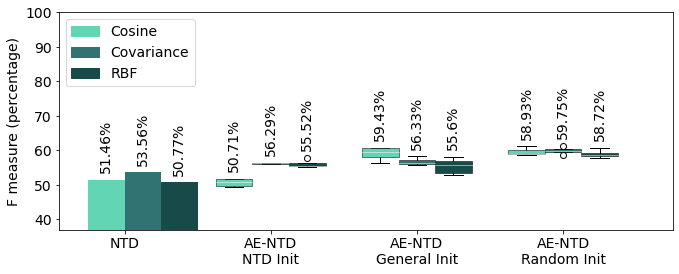

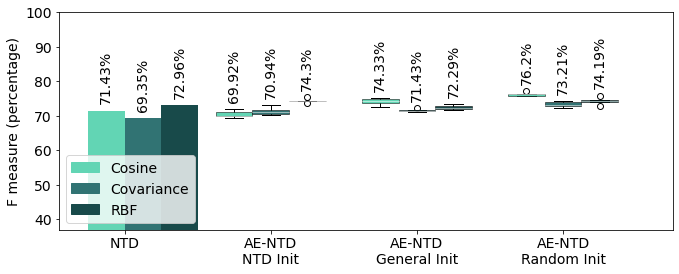

In [49]:
# AE NTD Euc
features = ["NTD","AE-NTD\nNTD Init","AE-NTD\nGeneral Init","AE-NTD\nRandom Init"]
res_ntd = math.inf * np.ones((len(autosimilarity_types), 2))
res_ntd[0,0] = 51.46 # Cos 05
res_ntd[0,1] = 71.43 # Cos 3
res_ntd[1,0] = 53.56 # Cov 05
res_ntd[1,1] = 69.35 # Cov 3
res_ntd[2,0] = 50.77 # RBF 05
res_ntd[2,1] = 72.96 # RBF 3

f_mes_cosine_zerofive = [[0.5178, 0.4967, 0.5154, 0.494, 0.5071],
                        [0.5943, 0.6076, 0.5793, 0.6062, 0.5624],
                        [0.589, 0.5874, 0.5893, 0.6108, 0.6013]]
f_mes_cosine_three = [[0.7196, 0.6947, 0.7106, 0.6988, 0.6992],
                     [0.7433, 0.7498, 0.7376, 0.75, 0.7255],
                     [0.7573, 0.7573, 0.7716, 0.762, 0.7627]]

f_mes_cov_zerofive = [[0.5635, 0.5603, 0.5629, 0.5631, 0.559],
                     [0.5611, 0.5836, 0.5633, 0.5714, 0.5571],
                     [0.5975, 0.585, 0.5959, 0.6136, 0.6022]]
f_mes_cov_three = [[0.703, 0.7048, 0.731, 0.7094, 0.7159],
                  [0.7114, 0.7227, 0.7164, 0.7139, 0.7143],
                  [0.7321, 0.7222, 0.729, 0.7412, 0.7392]]

f_mes_rbf_zerofive = [[0.5786, 0.5552, 0.5547, 0.5513, 0.5642],
                      [0.556, 0.5698, 0.5809, 0.5337, 0.5276],
                      [0.5783, 0.5924, 0.5872, 0.6072, 0.5824]]
f_mes_rbf_three = [[0.7541, 0.7431, 0.7424, 0.7362, 0.743],
                  [0.7229, 0.734, 0.7279, 0.7199, 0.7162],
                  [0.7278, 0.739, 0.7419, 0.7581, 0.7461]]

res_avg_target = math.inf * np.ones((len(features) - 1, len(autosimilarity_types), 2, 5))
for idx_f in range(len(features[1:])):
    res_avg_target[idx_f, 0, 0] = f_mes_cosine_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_cosine_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_cov_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_cov_three[idx_f]
    res_avg_target[idx_f, 2, 0] = f_mes_rbf_zerofive[idx_f]
    res_avg_target[idx_f, 2, 1] = f_mes_rbf_three[idx_f]
res_avg_target *= 100
plot_features_as_ntdae(res_ntd, res_avg_target, features, ["Cosine", "Covariance", "RBF"], 0, title = None)#f"F0.5 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")
plot_features_as_ntdae(res_ntd, res_avg_target, features, ["Cosine", "Covariance", "RBF"], 1, title = None)#f"F3 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")

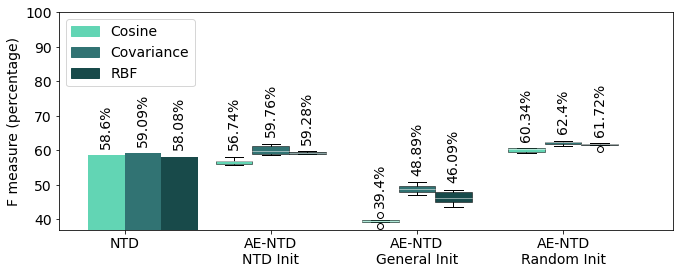

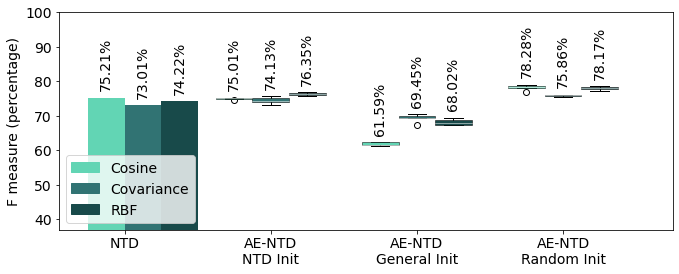

In [52]:
# AE NTD KL
features = ["NTD","AE-NTD\nNTD Init","AE-NTD\nGeneral Init","AE-NTD\nRandom Init"]
res_ntd = math.inf * np.ones((len(autosimilarity_types), 2))
res_ntd[0,0] = 58.60 # Cos 05
res_ntd[0,1] = 75.21 # Cos 3
res_ntd[1,0] = 59.09 # Cov 05
res_ntd[1,1] = 73.01 # Cov 3
res_ntd[2,0] = 58.08 # RBF 05
res_ntd[2,1] = 74.22 # RBF 3

f_mes_cosine_zerofive = [[0.5568, 0.5813, 0.5689, 0.5601, 0.5674],
                        [0.399, 0.4128, 0.381, 0.394, 0.3921],
                        [0.5916, 0.6066, 0.5953, 0.6034, 0.6051]]
f_mes_cosine_three = [[0.7464, 0.7493, 0.7501, 0.7509, 0.7524],
                     [0.6232, 0.6159, 0.6148, 0.6231, 0.6135],
                     [0.7864, 0.7691, 0.7828, 0.7803, 0.7902]]

f_mes_cov_zerofive = [[0.5901, 0.5976, 0.5859, 0.6115, 0.6194],
                     [0.4974, 0.4781, 0.4889, 0.47, 0.5082],
                     [0.624, 0.6244, 0.6273, 0.6166, 0.6135]]
f_mes_cov_three = [[0.7413, 0.7309, 0.7388, 0.7573, 0.7505],
                  [0.7043, 0.692, 0.6945, 0.6735, 0.7004],
                  [0.7588, 0.7532, 0.7564, 0.7606, 0.7586]]

f_mes_rbf_zerofive = [[0.5954, 0.5981, 0.5878, 0.5928, 0.5901],
                      [0.4857, 0.4782, 0.4609, 0.4364, 0.4486],
                      [0.6205, 0.6141, 0.6172, 0.6186, 0.6026]]
f_mes_rbf_three = [[0.7682, 0.7608, 0.7635, 0.7669, 0.7582],
                  [0.6946, 0.6874, 0.6802, 0.6742, 0.6721],
                  [0.785, 0.7729, 0.7817, 0.782, 0.7763]]

res_avg_target = math.inf * np.ones((len(features) - 1, len(autosimilarity_types), 2, 5))
for idx_f in range(len(features[1:])):
    res_avg_target[idx_f, 0, 0] = f_mes_cosine_zerofive[idx_f]
    res_avg_target[idx_f, 0, 1] = f_mes_cosine_three[idx_f]
    res_avg_target[idx_f, 1, 0] = f_mes_cov_zerofive[idx_f]
    res_avg_target[idx_f, 1, 1] = f_mes_cov_three[idx_f]
    res_avg_target[idx_f, 2, 0] = f_mes_rbf_zerofive[idx_f]
    res_avg_target[idx_f, 2, 1] = f_mes_rbf_three[idx_f]
res_avg_target *= 100
plot_features_as_ntdae(res_ntd, res_avg_target, features, ["Cosine", "Covariance", "RBF"], 0, title = None)#f"F0.5 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")
plot_features_as_ntdae(res_ntd, res_avg_target, features, ["Cosine", "Covariance", "RBF"], 1, title = None)#f"F3 for the Conv SSAE on RWC Pop,\n with the different autosimilarities.")